# aln-enrichment main
### Jaffe, Fuster et al. 2021

In [546]:
import re, glob, os, math, re, scipy, ecopy, gzip, pysam, random
from collections import defaultdict
from ete3 import Tree
import numpy as np
import pandas as pd
from Bio import SeqIO, SearchIO
import matplotlib.pyplot as plt
import subprocess as sp
import seaborn as sns
sns.set('notebook')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

import urllib
from Bio import Entrez
from multiprocessing import Pool
from bs4 import BeautifulSoup
Entrez.email = "alexander_jaffe@berkeley.edu"

In [547]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

In [548]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/aln/"
cmdir(rootdir)

# comm composition

### current

In [549]:
# read in color palette
raw = pd.read_csv(rootdir + "/dna/ggkbase_color_scheme.uppercase.csv", header=None, names=["lineage", "hex"])
ggcolors = {row["lineage"]: row["hex"] for key, row in raw.iterrows()}
# add fixes manually
ggcolors["PER-ii"] = ggcolors["Peregrinibacteria"]
ggcolors["unknown"] = "lightgrey"
ggcolors["RIF-WS3X"] = ggcolors['Rif-ws3x']
ggcolors["Candidate Phyla Radiation"] = "#B542B5"

In [550]:
# read in and plot - check no duplicate scaffolds
rac = pd.read_csv(rootdir + "dna/5295-ribosomal-protein-S3_in_LacPavin_0920_ALND.csv", header=None)
rac = rac[[0,3,5,10]]
rac.columns = ["scaffold", "Bin", "Coverage", "Phylum"]
rac["id"] = rac.index
rac["adj_phylum"] = rac["Phylum"].apply(lambda x: "Candidate Phyla Radiation" if x in ["Parcubacteria", "PER-ii"] else x)
rac["drep_genome"] = rac["Bin"].apply(lambda x: x in drep_genomes)

In [551]:
# make separate datasets
data1 = rac[(rac["id"]<50)]
data1["adj_coverage"] = data1.apply(lambda x: 0 if x["adj_phylum"] not in ["Planctomycetes", "Candidate Phyla Radiation"] else x["Coverage"], axis=1)
data2 = rac[(rac["id"]<50)]
data2["adj_coverage"] = data1.apply(lambda x: 0 if x["adj_phylum"] in ["Planctomycetes", "Candidate Phyla Radiation"]  else x["Coverage"], axis=1)
data2.head()

,scaffold,Bin,Coverage,Phylum,id,adj_phylum,drep_genome,adj_coverage
0,LacPavin_0920_ALND_scaffold_281956,LacPavin_0920_ALND_Planctomycetes_64_91,88.14,Planctomycetes,0,Planctomycetes,True,0.00
1,LacPavin_0920_ALND_scaffold_603991,LacPavin_0920_ALND_Burkholderiales_70_71,76.37,Proteobacteria,1,Proteobacteria,True,76.37
2,LacPavin_0920_ALND_scaffold_544059,LacPavin_0920_ALND_Actinobacteria_63_63,65.30,Actinobacteria,2,Actinobacteria,True,65.30
3,LacPavin_0920_ALND_scaffold_273213,LacPavin_0920_ALND_Nitrosoarchaeum_limnia_33_41,47.21,Thaumarchaeota,3,Thaumarchaeota,True,47.21
4,LacPavin_0920_ALND_scaffold_208593,LacPavin_0920_ALND_Planctomycetes_66_46,45.70,Planctomycetes,4,Planctomycetes,True,0.00


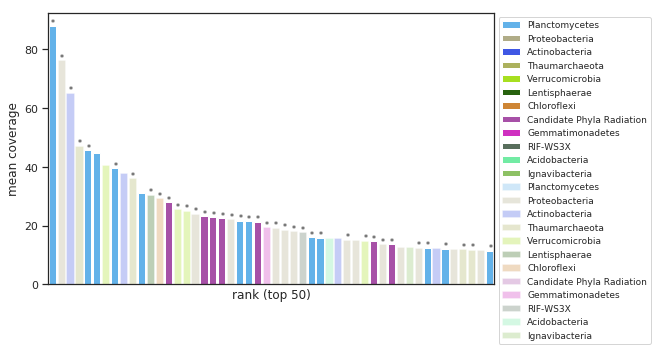

In [552]:
# rank abundance curve
plt.figure(figsize=(8,5))
sns.set_style("ticks")

g = sns.barplot(x="id", y="adj_coverage", data=data1, hue="adj_phylum", palette=ggcolors,dodge=False)
sns.barplot(x="id", y="adj_coverage", data=data2, hue="adj_phylum", alpha=0.30, palette=ggcolors,dodge=False)
g.set(xticks=[])
plt.xlabel("rank (top 50)")
plt.ylabel("mean coverage")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)

# add markers for binned?
for key, row in rac.query("id<50").iterrows():
    #if "UNK" not in row["Bin"]:
    if row["drep_genome"] == True:
        plt.text(row["id"] - 0.15, row["Coverage"]+0.01, "*", fontsize=8)

#plt.title("rps3 coverage > %d in %s" %(thresh, sample))
plt.savefig(rootdir + "dna/figures/rac.svg", format="svg")
plt.show()

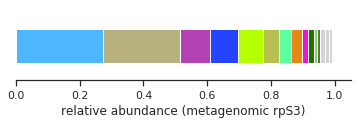

In [553]:
# compute + arrange
rac["perc_cov"] = rac["Coverage"].apply(lambda x: x/float(sum(rac["Coverage"])))
rac["sample"] = ""
racg = rac.groupby(["adj_phylum", "sample"], as_index=False).aggregate({"perc_cov": "sum"})
racp = racg.pivot("sample", "adj_phylum", "perc_cov")
order = racg.sort_values("perc_cov", ascending=False)["adj_phylum"].to_list()
# re-arrange so all grey together
order = [item for item in order if item in data1["adj_phylum"].unique()] + \
        [item for item in order if item not in data1["adj_phylum"].unique()]

# plot
color_map = [ggcolors[item] if item in data1["adj_phylum"].unique() else "lightgrey" for item in order]
g = racp.loc[:,order].plot.barh(color=color_map, stacked=True, figsize=(6,1.25), legend=False)
plt.xlabel("relative abundance (metagenomic rpS3)")
plt.ylabel("")
g.set(yticks=[])
sns.despine(left=True, right=True, top=True)
plt.savefig(rootdir + "dna/figures/marker_genes.svg", format="svg", bbox_inches="tight")
plt.show()

In [543]:
# write out supplementary table
rac_supp = rac
rac_supp["scaffold"] = rac_supp["scaffold"].apply(lambda x: x.replace("LacPavin", "LakeFargette"))
rac_supp["Bin"] = rac_supp["Bin"].apply(lambda x: x.replace("LacPavin", "LakeFargette"))
rac_supp = rac_supp[["scaffold", "Bin", "adj_phylum","drep_genome", "Coverage"]]
rac_supp.columns = ["scaffold", "bin", "lineage", "in_draft_genome", "coverage"]
rac_supp.to_csv(rootdir + "tables/rac_supp.tsv", sep="\t", index=False)

### past

In [554]:
fargette = pd.read_csv(rootdir + "dna/fargette_abundances.csv", sep="\t")
fargette.head()

,Sample,Acidobacteria,Actinobacteria,Armatimonadetes,Bacteroidetes,Microgenomates,OP3,Saccharibacteria,WS3,Chlamydiae,...,Planctomycetes,Proteobacteria,Spirochaetes,Ta06,Tenericutes,TM6,Unclassified,Verrucomicrobia,total,l
0,October,1.03,1.87,0.01,13.95,0.12,1.21,0.01,0.39,0.00,...,15.46,22.05,1.19,0.00,0.00,0.02,16.00,0.18,100,NaN
1,November,0.90,2.46,0.05,20.08,0.34,2.32,0.01,0.40,0.01,...,5.23,27.33,1.41,0.00,0.05,0.18,15.50,0.40,100,NaN
2,December,0.72,2.49,0.01,19.28,0.17,0.71,0.00,0.18,0.00,...,6.23,18.43,1.49,0.00,0.00,0.02,20.84,1.09,100,NaN
3,January,0.90,1.09,0.00,9.86,0.08,4.42,0.03,0.31,0.00,...,9.57,48.19,0.56,0.00,0.00,0.01,4.07,0.07,100,NaN
4,February,2.30,7.01,0.00,15.58,0.06,0.90,1.53,9.00,0.01,...,5.52,26.98,0.35,0.03,0.01,0.01,11.75,0.40,100,NaN


In [555]:
# reconstitute dataset
finfo = defaultdict(list)

for key, row in fargette.iterrows():

    for col in fargette.columns:
        if col != "Sample":
            finfo["Sample"].append(row["Sample"])
            finfo["Phylum"].append(col)
            finfo["fraction"].append(row[col]/100)

fdf = pd.DataFrame(finfo)
fdf.head()

,Sample,Phylum,fraction
0,October,Acidobacteria,0.0103
1,October,Actinobacteria,0.0187
2,October,Armatimonadetes,0.0001
3,October,Bacteroidetes,0.1395
4,October,Microgenomates,0.0012


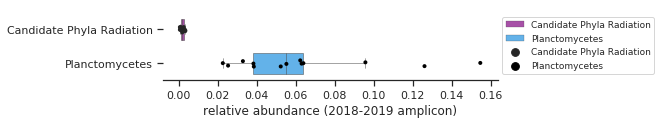

In [556]:
# arrange
fdf["adj_phylum"] = fdf["Phylum"].apply(lambda x: "Candidate Phyla Radiation" if x in ["Saccharibacateria", "Microgenomates"] else x)
fsub = fdf[fdf["adj_phylum"].isin(["Candidate Phyla Radiation", "Planctomycetes"])]

# plot
plt.figure(figsize=[6,1.25])
g = sns.boxplot(y="adj_phylum", x="fraction", data=fsub, width=0.6, dodge=False, hue="adj_phylum", palette=ggcolors, linewidth=0.5, fliersize=0)
sns.stripplot(y="adj_phylum", x="fraction", data=fsub, hue="adj_phylum", dodge=False, color="black", size=4)
sns.despine(left=True)
plt.xlabel("relative abundance (2018-2019 amplicon)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
plt.ylabel("")
plt.savefig(rootdir + "dna/figures/fargette.svg", format="svg")

In [ ]:
# difference
before = fdf.groupby(["adj_phylum"], as_index=False).aggregate({"fraction":"mean"})
before.columns = ["adj_phylum", "prelim_relative_abundance"]
after = racg[["adj_phylum", "perc_cov"]].rename(columns = {"perc_cov": "end_relative_abundance"})
# only take intersection
both = after.merge(before, how="inner", on="adj_phylum")
both["percent_change"] = both.apply(lambda x: (x["end_relative_abundance"] - x["prelim_relative_abundance"])/x["prelim_relative_abundance"], axis=1)
### make table
both.sort_values("end_relative_abundance", ascending=False).to_csv(rootdir + "tables/fold_change.tsv", sep="\t", index=False)
both.sort_values("end_relative_abundance", ascending=False)

# rna

In [ ]:
cmdir(rootdir + "rna")

### combine all genomes

In [32]:
# repredict genes for all
for genome in glob.glob(rootdir + "dna/genomes/final_genomes/*"):
    call = "prodigal -d %s -i %s -m -p single" %(genome.replace(".fna", ".genes.fna"), genome)
    #sp.call(call, shell=True)

prodigal -d /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/genomes/final_genomes/LacPavin_0920_ALND_PER-ii_52_24.genes.fna -i /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/genomes/final_genomes/LacPavin_0920_ALND_PER-ii_52_24.fna -m -p single


In [237]:
# add curated contigs to scaf2bin
curated_scafs = defaultdict(list)

for record in SeqIO.parse(open(rootdir + "dna/genomes/final_genomes/LacPavin_0920_ALND_PER-ii_52_24.fna"), "fasta"):
    curated_scafs["scaffold_name"].append(record.description.split(" ")[0])
    curated_scafs["bin"].append("LacPavin_0920_ALND_PER-ii_52_24")
    
scaf2bin = scaf2bin.query("bin!='LacPavin_0920_ALND_PER-ii_52_24'")
scaf2bin = pd.concat([scaf2bin, pd.DataFrame(curated_scafs)])

### map

Then combine into all_final_genomes.fna and build bt index: `cat ../dna/genomes/final_genomes/*[0-9].fna > all_final_genomes.fna`

In [39]:
# map reads to assembly
fwd_path = "/groups/banfield/sequences/2020/LacPavin_0920_ALNR/raw.d/LacPavin_0920_ALNR_trim_clean.PE.1.fastq.gz"
mapping = "/shared/software/bin/bowtie2 -p 20 -x " + rootdir + "rna/all_final_genomes.fna -1 " + \
    fwd_path + " -2 " + fwd_path.replace(".1.", ".2.") + " 2> " + rootdir + "rna/rna_mapping.log | " + \
    "/shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + rootdir + "rna/rna_mapping.bam"
print(mapping)

/shared/software/bin/bowtie2 -p 20 -x /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/all_final_genomes.fna -1 /groups/banfield/sequences/2020/LacPavin_0920_ALNR/raw.d/LacPavin_0920_ALNR_trim_clean.PE.1.fastq.gz -2 /groups/banfield/sequences/2020/LacPavin_0920_ALNR/raw.d/LacPavin_0920_ALNR_trim_clean.PE.2.fastq.gz 2> /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/rna_mapping.log | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/rna_mapping.bam


In [46]:
# generate sorted bam + idx
sort = "/shared/software/bin/samtools sort --threads 20 " + rootdir + "rna/rna_mapping.bam > " + rootdir + "rna/rna_mapping.sorted.bam"
index = "/shared/software/bin/samtools index -@ 20 " + rootdir + "rna/rna_mapping.sorted.bam"
print(index)

/shared/software/bin/samtools index -@ 20 /groups/banfield/projects/environmental/LacPavin/analysis/aln/rna/rna_mapping.sorted.bam


### quality filter

In [47]:
# generate gene list
genes = []

for geneset in glob.glob(rootdir + "dna/genomes/final_genomes/*genes.fna"):
    for record in SeqIO.parse(open(geneset), "fasta"):
        genes.append([record.description.split(" # ")[0], record.description.split(" # ")[1], record.description.split(" # ")[2]])
    
genes[0]

['LacPavin_0920_ALND_scaffold_53722_1', '40', '1005']

In [52]:
# compute per gene
read_data = defaultdict(list)
bamfile = pysam.AlignmentFile(rootdir + "rna/rna_mapping.sorted.bam")

for gene in genes:
    
    read_data["scaffold_name"].append(scaffold(gene[0]))
    read_data["gene"].append(gene[0])
    read_data["read_count"].append(len([read for read in \
        bamfile.fetch(scaffold(gene[0]), int(gene[1]), int(gene[2]))]))
    
read_df = pd.DataFrame(read_data)
read_df.head()

,scaffold_name,gene,read_count
0,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_1,0
1,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_2,0
2,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_3,0
3,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_4,0
4,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_5,0


In [57]:
read_df = read_df.merge(scaf2bin[["scaffold_name", "bin"]], how="left")
genes_to_remove = []

for bin in read_df["bin"].unique():
    
    subtable = read_df[read_df["bin"]==bin]
    counts = subtable["read_count"].to_list()
    median = np.median([count for count in counts if count != 0])
    
    for i, count in enumerate(counts):
        if count > (median*100):
            genes_to_remove.append(subtable["gene"].to_list()[i])

In [61]:
rnatable = read_df[~read_df["gene"].isin(genes_to_remove)]
rnatable = rnatable.merge(curated_md[["genome", "lineage"]], how="left", left_on="bin", right_on="genome").drop("genome", axis=1)
rnatable.head()

,scaffold_name,gene,read_count,bin,lineage
0,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_1,0,LacPavin_0920_ALND_Nitrosoarchaeum_33_12,Thaumarchaeota
1,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_2,0,LacPavin_0920_ALND_Nitrosoarchaeum_33_12,Thaumarchaeota
2,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_3,0,LacPavin_0920_ALND_Nitrosoarchaeum_33_12,Thaumarchaeota
3,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_4,0,LacPavin_0920_ALND_Nitrosoarchaeum_33_12,Thaumarchaeota
4,LacPavin_0920_ALND_scaffold_53722,LacPavin_0920_ALND_scaffold_53722_5,0,LacPavin_0920_ALND_Nitrosoarchaeum_33_12,Thaumarchaeota


### plot

In [63]:
# modify taxnomy to match rps3 bar
replacements = {"Betaproteobacteria": "Proteobacteria", "Deltaproteobacteria": "Proteobacteria", "Burkholderiales": "Proteobacteria",
               "Alphaproteobacteria": "Proteobacteria", "WS3X": "RIF-WS3X", "CPR": "Candidate Phyla Radiation"}
rnatable["adj_lineage"] = rnatable["lineage"].apply(lambda x: replacements[x] if x in replacements.keys() else x)

In [64]:
rgb = rnatable.groupby("adj_lineage", as_index=False).aggregate({"read_count":"sum"})
rgb["read_total"] = sum(rnatable["read_count"])
rgb["fraction_mapped_reads"] = rgb.apply(lambda x: x["read_count"]/x["read_total"], axis=1)
rgb["sample"] = "ALNR"
rgp = rgb.pivot("sample", "adj_lineage", "fraction_mapped_reads").fillna(0)
rgp

adj_lineage,Actinobacteria,Armatimonadetes,Bacteroidetes,Candidate Phyla Radiation,Chloroflexi,Gemmatimonadetes,Lentisphaerae,Nitrospirae,Planctomycetes,Proteobacteria,RIF-WS3X,Spirochaetes,Thaumarchaeota,Verrucomicrobia
sample,,,,,,,,,,,,,,
ALNR,0.017779,0.010639,0.018086,0.010277,0.021173,0.018706,0.056578,0.014638,0.271291,0.330392,0.012011,0.105248,0.104668,0.008513


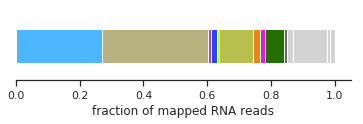

In [71]:
rna_order = [item for item in order if item in rgp.columns] + [item for item in rgp.columns if item not in order]
color_map = [ggcolors[item] if item in data1["adj_phylum"].unique() else "lightgrey" for item in rna_order]

sns.set_style("ticks")
g = rgp.loc[:,rna_order].plot.barh(color=color_map, stacked=True, figsize=(6,1.25), legend=False)
g.set(yticks=[])
plt.xlabel("fraction of mapped RNA reads")
plt.ylabel("")
sns.despine(left=True, right=True, top=True)
plt.savefig(rootdir + "dna/figures/rna_bar.svg", format="svg", bbox_inches="tight")
plt.show()

# gene content

In [ ]:
cmdir(rootdir + "dna/metabolism")

### subset

In [ ]:
cmdir(rootdir + "dna/genomes/analysis_subset")

In [94]:
for key, row in curated_md.iterrows():
    if row["lineage"] in ["CPR", "Planctomycetes"]:
        call = "cp " + rootdir + "dna/genomes/final_genomes/" + \
            row["genome"] + ".fna " + rootdir + "dna/genomes/analysis_subset/"
        sp.call(call, shell=True)

### gene prediction

In [95]:
for genome in glob.glob(rootdir + "dna/genomes/analysis_subset/*"):
    call = "prodigal -a %s -i %s -m -p single" %(genome.replace(".fna", ".faa"), genome)
    sp.call(call, shell=True)

In [97]:
with open(rootdir + "dna/metabolism/all_subset_proteins.faa", "w") as out:
    for proteome in glob.glob(rootdir + "dna/genomes/analysis_subset/*faa"):
        for record in SeqIO.parse(open(proteome), "fasta"):
            out.write(">%s\n%s\n" %(record.description, str(record.seq)))

### run kofamscan

In [99]:
# launch kofamscan
kocall = "sbatch -J kfscan --wrap '/shared/software/kofamscan/latest/exec_annotation -o " + rootdir + \
    "dna/metabolism/kofamscan.latest.txt " + rootdir + "dna/metabolism/all_subset_proteins.faa" + \
    " -p /shared/db/kegg/kofam/latest/profiles/prokaryote.hal " + \
    "-k /shared/db/kegg/kofam/latest/metadata/ko_list --cpu 20 -f detail'"
print(kocall)

sbatch -J kfscan --wrap '/shared/software/kofamscan/latest/exec_annotation -o /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/metabolism/kofamscan.latest.txt /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/metabolism/all_subset_proteins.faa -p /shared/db/kegg/kofam/latest/profiles/prokaryote.hal -k /shared/db/kegg/kofam/latest/metadata/ko_list --cpu 20 -f detail'


In [560]:
# read in output
buffer = []
for line in open(rootdir + "dna/metabolism/kofamscan.latest.txt").readlines():
    if "#" not in line:
        # hilariously long regex
        m = re.search("[* ]*([\S]+)\s+([\S]+)\s+([0-9.-]+)\s+" + \
            "([0-9.-]+)\s+([0-9.+-e]+)\s(.+?$)", line.strip())
        try:
            buffer.append(m.groups())
        except:
            print(line)

kodf = pd.DataFrame.from_records(buffer, columns =["gene", "ko", "threshold", "score", "eval", "def"]) 
buffer=[]

In [561]:
# filter for significance
kodf["eval"] = kodf["eval"].apply(lambda x: float(x))
kodf["score"] = kodf["score"].apply(lambda x: float(x))
kodf = kodf[kodf["eval"] < 1e-6]
# get best hit per gene based on score
kfilt = kodf.sort_values('score', ascending=False).drop_duplicates("gene")
kfilt.head()

,gene,ko,threshold,score,eval,def
17988,LacPavin_0920_ALND_scaffold_62933_3,K13688,815.23,3499.5,0.0,"cyclic beta-1,2-glucan synthetase [EC:2.4.1.-]"
655135,LacPavin_0920_ALND_scaffold_1095959_23,K13688,815.23,3468.2,0.0,"cyclic beta-1,2-glucan synthetase [EC:2.4.1.-]"
435055,LacPavin_0920_ALND_scaffold_205859_110,K13688,815.23,3328.6,0.0,"cyclic beta-1,2-glucan synthetase [EC:2.4.1.-]"
606571,LacPavin_0920_ALND_scaffold_454205_27,K00265,2001.07,2375.9,0.0,glutamate synthase (NADPH) large chain [EC:1.4...
200638,LacPavin_0920_ALND_scaffold_438593_2,K00265,2001.07,2288.0,0.0,glutamate synthase (NADPH) large chain [EC:1.4...


### build plancto ref set

In [ ]:
cmdir(rootdir + "dna/phylo")
cmdir(rootdir + "dna/phylo/plancto")
cmdir(rootdir + "dna/phylo/plancto/fasta")
cmdir(rootdir + "dna/phylo/plancto/protein")

In [ ]:
gtdb = pd.read_csv(rootdir + "dna/phylo/bac120_metadata_r202.tsv", sep="\t")
gtdb_subset = gtdb[gtdb["gtdb_taxonomy"].str.contains("Plancto")]
gtdb_subset["species"] = gtdb["gtdb_taxonomy"].apply(lambda x: x.split(";")[6])
gtdb_subset = gtdb_subset.drop_duplicates("species")
print(str(len(gtdb_subset)) + " genomes selected.")

In [ ]:
for accession in gtdb_subset["accession"]:
    
    try:
        # query for accession
        handle = Entrez.esearch(db= "assembly", term=accession.replace("GB_",""))
        # read in resultss
        results = Entrez.read(handle)
        # grab ID
        ident = results["IdList"][0]
        handle.close()

        # instead, go through ftp link
        handle = Entrez.efetch(db="assembly", id=ident, rettype="docsum")
        # get ftp base path
        ftp = BeautifulSoup(handle).find("ftppath_genbank").string
        # construct ftp request
        fna_name = ftp.split("/")[-1] + "_genomic.fna.gz"
        furl = ftp + "/" + fna_name

        if glob.glob(rootdir + "dna/phylo/plancto/fasta/" + fna_name) == []:
            urllib.request.urlretrieve(furl, rootdir + "dna/phylo/plancto/fasta/" + fna_name)
        handle.close()
    
    except: continue

In [ ]:
def predict(path):

    basename = os.path.basename(path).replace(".fna", "")

    call = "prodigal -m -i " + path + " -a " + rootdir + \
        "dna/phylo/plancto/protein/" + basename + ".faa"
    sp.call(call, shell=True)

In [ ]:
p = Pool(20)
pools = p.map(predict, glob.glob(rootdir + "dna/phylo/plancto/fasta/*fna"))

Manually combine all protein predictions.

In [ ]:
# predict s3
call = "hmmsearch --cut_nc --tblout " + rootdir + "dna/phylo/plancto/plancto_s3.results " + \
    "/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/proteins/hmms/TIGR01009.HMM " + \
    rootdir + "dna/phylo/plancto/all_plancto_proteins.faa"
print(call)

Then use hmm2fasta.sh to extract faa hits.

### s3 phylogenetics

In [562]:
# merge in lineage info
kfilt["scaffold_name"] = kfilt["gene"].apply(lambda x: scaffold(x).replace("-", "").replace("PERii", "PER-ii"))
kfilt = kfilt.merge(scaf2bin[["scaffold_name", "bin"]], how="left", on="scaffold_name").merge(curated_md[["genome", "lineage"]], how="left", left_on="bin", right_on="genome").drop(["genome"], axis=1)

In [ ]:
with open(rootdir + "dna/phylo/run_phylogenetics.sh", "w") as wrapper:
    
    for lineage in ["CPR", "Planctomycetes"]:

        # extract ALN marker genes
        basename = rootdir + "dna/phylo/aln_" + lineage.lower() + "_s3.txt"
        kfilt[(kfilt["lineage"]==lineage) & (kfilt["ko"]=='K02982')]["gene"].str.replace("-", "*-").to_csv(basename, index=False, header=None)
        call = "pullseq -n " + basename + " -i " + rootdir + "dna/metabolism/all_subset_proteins.faa > " + basename.replace(".txt", ".faa")
        wrapper.write(call + "\n")

        # find ref sets
        if lineage == "Planctomycetes":
            refset = [rootdir + "dna/phylo/plancto/plancto_s3.faa",
                      "/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/genomes/bac175/hmm_results/TIGR01009.B175.trimmed.faa"]
        else: refset = ["/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/" + \
            "trees/bac175_outgroup/TIGR01009.BAC175.concat.faa"]

        # concat ref sets
        call = "cat " + basename.replace(".txt", ".faa") + " " + \
            " ".join(refset) + " > " + basename.replace(".txt", ".concat.faa")
        wrapper.write(call + "\n")

        # align
        call = "mafft --auto --thread 16 " + basename.replace(".txt", ".concat.faa") + " > " + \
            basename.replace(".txt", ".concat.mafft")
        wrapper.write(call + "\n")
        
        # trim
        call = "trimal -in " + basename.replace(".txt", ".concat.mafft") + " -out " + \
            basename.replace(".txt", ".trimmed.mafft") + " -gt 0.1"
        wrapper.write(call + "\n")
        
        # tree build
        call = "iqtree -s " + basename.replace(".txt", ".trimmed.mafft") + \
            " -m TEST -safe -st AA -bb 1500 -nt AUTO -ntmax 20 -pre " + basename.replace(".txt", "")
        wrapper.write(call + "\n")

In [ ]:
# prep plancto naming dicts
p_scaf2bin = {}

for genome in glob.glob(rootdir + "dna/phylo/plancto/fasta/*"):
    name = "_".join(os.path.basename(genome).split("_")[0:2])
    for record in SeqIO.parse(open(genome), "fasta"):
        p_scaf2bin[record.description.split(" ")[0]] = name

gdict = {"_".join(row["accession"].split("_")[1:3]).replace("GCF", "GCA"): row["gtdb_taxonomy"] for key, row in gtdb_subset.iterrows()}
pdict = {key: gdict[p_scaf2bin[key]] for key in p_scaf2bin.keys()}
pcolors = {c: sns.color_palette("Set3").as_hex()[i%len(sns.color_palette("Set3").as_hex())] 
                for i,c in enumerate(set(item.split(";")[2] for key, item in pdict.items()))}

In [ ]:
# prep cpr naming
c_scaf2bin = {}

for genome in glob.glob("/groups/banfield/users/ajaffe/cpr-dpann/nr-set-complete/dRep-workspace-95/dereplicated_genomes/*"):
    name = os.path.basename(genome).split(".contigs")[0]
    for record in SeqIO.parse(open(genome), "fasta"):
        c_scaf2bin[record.description.split(" ")[0]] = name
        
cdict = {row["name"]: row["revised_tax"] for key, row in pd.read_csv("/groups/banfield/projects/environmental/LacPavin/analysis/phylo/cpr/jaffe_et_al_s1.tsv", sep="\t").iterrows()}

In [ ]:
# modify trees

for lineage in ["CPR"]:
    
    path = glob.glob(rootdir + "dna/phylo/*" + lineage.lower() + "*s3.treefile")[0]
    itol = open(rootdir + "dna/phylo/" + lineage.lower() + ".itol.txt", "w")
    itol.write("TREE_COLORS\nSEPARATOR TAB\nDATA\n")
    t = Tree(path)
    
    for leaf in t:
        
        if lineage == "Planctomycetes":
            
            # only select NCBI genomes
            if len(re.search("[A-Z0-9]+", leaf.name).group(0)) > 2:
                newname = leaf.name + " " + pdict[scaffold(leaf.name)]
                c = newname.split(";")[2]
                itol.write(newname.replace(";", "_") + "\trange\t%s\t%s\n" %(pcolors[c], c))
                leaf.name = newname
                
        else:
            
            if scaffold(leaf.name) in c_scaf2bin.keys():
                newname = c_scaf2bin[scaffold(leaf.name)] + \
                    " (" + cdict[c_scaf2bin[scaffold(leaf.name)]] + ")"
                leaf.name = newname
            if "LacPavin" in leaf.name:
                itol.write(leaf.name + "\trange\t%s\t%s\n" %("red", "CPR"))

    t.write(outfile=path.replace(".treefile", ".renamed.treefile"), format=2)      
    itol.close()

### identifiers

In [563]:
genome_ids = {  "LacPavin_0920_ALND_scaffold_515556_10": "P1",
                 "LacPavin_0920_ALND_scaffold_186177_4": "P2",
                 "LacPavin_0920_ALND_scaffold_208593_193": "P3",
                 "LacPavin_0920_ALND_scaffold_281956_173": "P4",
                 "LacPavin_0920_ALND_scaffold_231019_36": "P5",
                 "LacPavin_0920_ALND_scaffold_441425_6": "P6",
                 "LacPavin_0920_ALND_scaffold_299947_31": "P7",
                 "LacPavin_0920_ALND_scaffold_1061080_1": "P8",
                 "LacPavin_0920_ALND_scaffold_596440_3": "P9",
                 "LacPavin_0920_ALND_scaffold_13249_13": "P10",
                 "LacPavin_0920_ALND_scaffold_680977_13": "P11",
                 "LacPavin_0920_ALND_scaffold_58038_2": "P12",
                 "LacPavin_0920_ALND_scaffold_272472_124": "C1",
                 "LacPavin_0920_ALND_PER-ii_52_24_curated_scaffold_1_206": "C2",
                 "LacPavin_0920_ALND_scaffold_118019_144": "C3",
                 "LacPavin_0920_ALND_scaffold_491135_60": "C4",
                 "LacPavin_0920_ALND_scaffold_894461_142": "C5",
                 "LacPavin_0920_ALND_scaffold_312775_7": "C6",
                 "LacPavin_0920_ALND_scaffold_217289_11": "C7",
                 "LacPavin_0920_ALND_scaffold_222078_5": "C8",
                 "LacPavin_0920_ALND_scaffold_493788_108": "C9"
              }

In [564]:
# use scaf2bin to map back to genome
genome2id = {}

for key, item in genome_ids.items():
    scaf = scaffold(key)
    bin = scaf2bin[scaf2bin["scaffold_name"]==scaf]["bin"].iloc[0]
    genome2id[bin] = item

### metabolism

In [565]:
kmod = kfilt.query("threshold!='-'")
kmod["threshold"] = kmod["threshold"].apply(lambda x: float(x))
kmod = kmod[kmod["score"]>=kmod["threshold"]]

In [566]:
# make kegg decoder input
decoder_info = defaultdict(list)

for proteome in glob.glob(rootdir + "dna/genomes/analysis_subset/*faa"):
    
    orf_count = 1
    name = os.path.basename(proteome).split(".faa")[0]
    
    for record in SeqIO.parse(open(proteome), "fasta"):
        
        decoder_info["genome"].append(name)
        decoder_info["gene"].append(record.description.split(" ")[0].replace("*", ""))
        shortname = "".join(name.split("_")[-3:])
        decoder_info["decoder_genome"].append(shortname)
        decoder_info["decoder_gene"].append(shortname + "_" + str(orf_count))
        orf_count +=1

decoder_df = pd.DataFrame(decoder_info).merge(kmod[["gene", "ko"]], how="left").fillna("")
decoder_df.head()

,genome,gene,decoder_genome,decoder_gene,ko
0,LacPavin_0920_ALND_Planctomycetia_61_12,LacPavin_0920_ALND_scaffold_111831_1,Planctomycetia6112,Planctomycetia6112_1,
1,LacPavin_0920_ALND_Planctomycetia_61_12,LacPavin_0920_ALND_scaffold_111831_2,Planctomycetia6112,Planctomycetia6112_2,
2,LacPavin_0920_ALND_Planctomycetia_61_12,LacPavin_0920_ALND_scaffold_111831_3,Planctomycetia6112,Planctomycetia6112_3,K09778
3,LacPavin_0920_ALND_Planctomycetia_61_12,LacPavin_0920_ALND_scaffold_111831_4,Planctomycetia6112,Planctomycetia6112_4,
4,LacPavin_0920_ALND_Planctomycetia_61_12,LacPavin_0920_ALND_scaffold_111831_5,Planctomycetia6112,Planctomycetia6112_5,


In [567]:
# write out for decoder
decoder_df[["decoder_gene", "ko"]].to_csv(rootdir + "dna/metabolism/decoder_input.tsv", index=False, sep="\t", header=None)

In [568]:
# read in decoder results
decoder_results = pd.read_csv(rootdir + "dna/metabolism/decoder_output.tsv", sep="\t")

functions = ["Function", "glycolysis", "gluconeogenesis", "TCA Cycle", "F-type ATPase",
             "Cytochrome c oxidase", #"hydroxylamine oxidation", #"ammonia oxidation (amo/pmmo)",
             "nitrite oxidation", "dissim nitrate reduction",'DNRA', 'nitrite reduction']
             #'nitric oxide reduction','nitrous-oxide reduction', 'nitrogen fixation']

decoder_subset = decoder_results[functions].merge(decoder_df.drop_duplicates("genome")[["genome", "decoder_genome"]], how="left", left_on="Function", right_on="decoder_genome").drop(["decoder_genome", "Function"], axis=1)
decoder_subset.head()

,glycolysis,gluconeogenesis,TCA Cycle,F-type ATPase,Cytochrome c oxidase,nitrite oxidation,dissim nitrate reduction,DNRA,nitrite reduction,genome
0,0.56,0.56,0.62,1.000,1.00,0,0,0,0,LacPavin_0920_ALND_Planctomycetia_61_12
1,0.22,0.00,0.00,0.750,0.00,0,0,0,0,LacPavin_0920_ALND_Parcubacteria_55_23
2,0.67,0.78,0.75,1.000,0.75,0,0,1,0,LacPavin_0920_ALND_Planctomycetes_68_24
3,0.33,0.00,0.00,0.750,0.00,0,0,0,0,LacPavin_0920_ALND_Nomurabacteria_36_7
4,0.44,0.56,0.50,0.875,0.50,0,0,0,0,LacPavin_0920_ALND_Planctomycetales_59_8


### crispr targeting

In [269]:
import skbio

In [ ]:
call = "/groups/banfield/users/linking/overlap-based-assembly/CRISPR.v5.py -f " + \
    "/groups/banfield/projects/environmental/LacPavin/QB3_09_14_20/assembly.d/" + \
    "ALND/megahit/LacPavin_0920_ALND_scaffold_min1000.fa -m  /groups/banfield/projects/" + \
    "environmental/LacPavin/analysis/aln/dna/mapping/mapping.bam -c 20 -n 20 -o " + rootdir + "dna/crispr"
print(call)

In [569]:
# parse
sysinfo = pd.read_csv(rootdir + "dna/crispr/identified.CRISPR-Cas.system.info.txt", sep="\t").rename(columns={"Sequence": "scaffold_name"})
sysinfo = sysinfo.merge(scaf2bin[["scaffold_name", "bin"]], how="left")
sysinfo["CRISPR locus"] = True
sysinfo

,scaffold_name,Repeat_region,Repeat_seq,Cas_proteins,Num_unique_sequence_spacers,Num_unique_read_spacers,Unnamed: 6,bin,CRISPR locus
0,LacPavin_0920_ALND_scaffold_30274,128992-130788,ATGAATCGATCAGTGACGCCCCCGGGCGTTGAGCAC,"cas6_cmx6,cas3_core,cas_csx13_N,cas_csx13_C,ca...",26,86,NaN,LacPavin_0920_ALND_Planctomycetia_67_38,True
1,LacPavin_0920_ALND_scaffold_133155,41-1094,CTCTCCGCCGTCGCAAGACGGCGGCTCCATTGAAGC,"cas4,cas1_MYXAN,cas2,cas3_GSU0051",13,22,NaN,LacPavin_0920_ALND_Bacteria_70_12,True
2,LacPavin_0920_ALND_scaffold_354373,37565-37904,CGTCGTCCCCACGCACGTGGGGCTGATCCG,"cas3_HD,cas3_core,casA_cse1,casB_cse2,casC_Cse...",21,38,NaN,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True
3,LacPavin_0920_ALND_scaffold_354373,38402-40252,GTCGTCCCCACGCACGTGGGGCTGATCC,"cas3_HD,cas3_core,casA_cse1,casB_cse2,casC_Cse...",45,70,NaN,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True
4,LacPavin_0920_ALND_scaffold_354373,40617-41603,CGTCCCCACGCACGTGGGGCTGATCCG,"casA_cse1,casB_cse2,casC_Cse4,casD_Cas5e,casE_...",44,78,NaN,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True
5,LacPavin_0920_ALND_scaffold_354373,41996-42337,GTCGTCCCCACGCACGTGGGGCTGATCCG,"casA_cse1,casB_cse2,casC_Cse4,casD_Cas5e,casE_...",44,68,NaN,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True
6,LacPavin_0920_ALND_scaffold_387648,3560-3991,ATTCTAGACGATTGGGATTTGCGCTCTGGCCGGAAC,"cas_Csn1,cas1_NMENI,cas2",15,25,NaN,LacPavin_0920_ALND_UNK,True
7,LacPavin_0920_ALND_scaffold_507521,9-860,GCTTCAATTCGGCCACGGCGTTGAGCCGTGGAGAACC,"cas3_GSU0051,cas3_GSU0051,cas5_6_GSU0054,cas7_...",25,56,NaN,LacPavin_0920_ALND_Planctomycetes_60_11,True
8,LacPavin_0920_ALND_scaffold_649418,69-981,GCTTCAATTCGGCCACGGCGGTGAGCCGTGGATGAC,"cas5_6_GSU0054,cas7_GSU0053,cas_csx17,cas3_GSU...",12,31,NaN,LacPavin_0920_ALND_Planctomycetes_60_11,True
9,LacPavin_0920_ALND_scaffold_886833,706-1136,GTTGCGGATTGCTGACAGGCGGGGATCAGTTACACT,"cas2,cas1_NMENI,cas_Csn1",31,54,NaN,LacPavin_0920_ALND_Planctomycetes_59_20,True


In [570]:
# parse blast hits
bresults = skbio.io.read(rootdir + "dna/crispr/query.for.targeting.search.fasta.blastn.spacers.fasta", format="blast+6", into=pd.DataFrame, default_columns=True)
# read in spacer length
spacer_lens = {record.description.split(" ")[0]:len(record.seq) for record in SeqIO.parse(open(rootdir + "dna/crispr/spacers.fasta"), "fasta")}
bresults["spacer_len"] = bresults["sseqid"].map(spacer_lens)
bresults["spacer_coverage"] = bresults.apply(lambda x: abs((x["send"] - x["sstart"])/x["spacer_len"]*100), axis=1)
# filter hits
bfilt = bresults[(bresults["spacer_coverage"]>=90) & (bresults["mismatch"] <= 2)]
bfilt["targeting_scaffold"] = bfilt["sseqid"].apply(lambda x: x.split("_region")[0])
bfilt = bfilt.merge(scaf2bin[["scaffold_name", "bin"]], how="left", left_on="targeting_scaffold", right_on="scaffold_name").drop("scaffold_name", axis=1)
# only look at those targeted by plancto
bfilt[bfilt["targeting_scaffold"].isin(sysinfo[sysinfo["bin"].str.contains("Plancto")]["scaffold_name"].to_list())]

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,spacer_len,spacer_coverage,targeting_scaffold,bin
0,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,100.000,34.0,0.0,0.0,46288.0,46321.0,1.0,34.0,7.440000e-11,62.6,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38
1,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,100.000,33.0,0.0,0.0,46288.0,46320.0,1.0,33.0,2.600000e-10,60.8,34,94.117647,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38
2,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,97.059,34.0,1.0,0.0,46288.0,46321.0,1.0,34.0,3.170000e-09,58.1,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38
3,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,97.059,34.0,1.0,0.0,46288.0,46321.0,1.0,34.0,3.170000e-09,58.1,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38
4,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,97.059,34.0,1.0,0.0,46288.0,46321.0,1.0,34.0,3.170000e-09,58.1,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38
5,LacPavin_0920_ALND_scaffold_280696,LacPavin_0920_ALND_scaffold_886833_region_706_...,92.857,28.0,2.0,0.0,10845.0,10872.0,2.0,29.0,1.720000e-05,42.8,29,93.103448,LacPavin_0920_ALND_scaffold_886833,LacPavin_0920_ALND_Planctomycetes_59_20
8,LacPavin_0920_ALND_scaffold_377907,LacPavin_0920_ALND_scaffold_507521_region_9_86...,100.000,37.0,0.0,0.0,945.0,981.0,37.0,1.0,4.240000e-14,68.0,37,97.297297,LacPavin_0920_ALND_scaffold_507521,LacPavin_0920_ALND_Planctomycetes_60_11
9,LacPavin_0920_ALND_scaffold_377907,LacPavin_0920_ALND_scaffold_507521_region_9_86...,97.297,37.0,1.0,0.0,945.0,981.0,37.0,1.0,1.800000e-12,63.5,37,97.297297,LacPavin_0920_ALND_scaffold_507521,LacPavin_0920_ALND_Planctomycetes_60_11
10,LacPavin_0920_ALND_scaffold_377907,LacPavin_0920_ALND_scaffold_507521_region_9_86...,94.595,37.0,2.0,0.0,945.0,981.0,37.0,1.0,2.200000e-11,59.0,37,97.297297,LacPavin_0920_ALND_scaffold_507521,LacPavin_0920_ALND_Planctomycetes_60_11
18,LacPavin_0920_ALND_scaffold_779087,LacPavin_0920_ALND_scaffold_30274_region_12899...,94.286,35.0,2.0,0.0,2622.0,2656.0,35.0,1.0,5.180000e-10,55.4,36,94.444444,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38


In [571]:
# select actual phages
confirmed_phages = ["LacPavin_0920_ALND_scaffold_64753"]
bsub = bfilt[bfilt["qseqid"].isin(confirmed_phages)].drop_duplicates(["qseqid", "bin"])
bsub["targets curated phage"] = True
bsub

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,spacer_len,spacer_coverage,targeting_scaffold,bin,targets curated phage
0,LacPavin_0920_ALND_scaffold_64753,LacPavin_0920_ALND_scaffold_30274_region_12899...,100.0,34.0,0.0,0.0,46288.0,46321.0,1.0,34.0,7.440000e-11,62.6,34,97.058824,LacPavin_0920_ALND_scaffold_30274,LacPavin_0920_ALND_Planctomycetia_67_38,True


In [572]:
sysinfo = sysinfo.merge(bsub[["bin", "targets curated phage"]], how="left", on="bin").fillna("False")
sysinfo

,scaffold_name,Repeat_region,Repeat_seq,Cas_proteins,Num_unique_sequence_spacers,Num_unique_read_spacers,Unnamed: 6,bin,CRISPR locus,targets curated phage
0,LacPavin_0920_ALND_scaffold_30274,128992-130788,ATGAATCGATCAGTGACGCCCCCGGGCGTTGAGCAC,"cas6_cmx6,cas3_core,cas_csx13_N,cas_csx13_C,ca...",26,86,False,LacPavin_0920_ALND_Planctomycetia_67_38,True,True
1,LacPavin_0920_ALND_scaffold_133155,41-1094,CTCTCCGCCGTCGCAAGACGGCGGCTCCATTGAAGC,"cas4,cas1_MYXAN,cas2,cas3_GSU0051",13,22,False,LacPavin_0920_ALND_Bacteria_70_12,True,False
2,LacPavin_0920_ALND_scaffold_354373,37565-37904,CGTCGTCCCCACGCACGTGGGGCTGATCCG,"cas3_HD,cas3_core,casA_cse1,casB_cse2,casC_Cse...",21,38,False,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True,False
3,LacPavin_0920_ALND_scaffold_354373,38402-40252,GTCGTCCCCACGCACGTGGGGCTGATCC,"cas3_HD,cas3_core,casA_cse1,casB_cse2,casC_Cse...",45,70,False,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True,False
4,LacPavin_0920_ALND_scaffold_354373,40617-41603,CGTCCCCACGCACGTGGGGCTGATCCG,"casA_cse1,casB_cse2,casC_Cse4,casD_Cas5e,casE_...",44,78,False,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True,False
5,LacPavin_0920_ALND_scaffold_354373,41996-42337,GTCGTCCCCACGCACGTGGGGCTGATCCG,"casA_cse1,casB_cse2,casC_Cse4,casD_Cas5e,casE_...",44,68,False,LacPavin_0920_ALND_Deltaproteobacteria_72_12,True,False
6,LacPavin_0920_ALND_scaffold_387648,3560-3991,ATTCTAGACGATTGGGATTTGCGCTCTGGCCGGAAC,"cas_Csn1,cas1_NMENI,cas2",15,25,False,LacPavin_0920_ALND_UNK,True,False
7,LacPavin_0920_ALND_scaffold_507521,9-860,GCTTCAATTCGGCCACGGCGTTGAGCCGTGGAGAACC,"cas3_GSU0051,cas3_GSU0051,cas5_6_GSU0054,cas7_...",25,56,False,LacPavin_0920_ALND_Planctomycetes_60_11,True,False
8,LacPavin_0920_ALND_scaffold_649418,69-981,GCTTCAATTCGGCCACGGCGGTGAGCCGTGGATGAC,"cas5_6_GSU0054,cas7_GSU0053,cas_csx17,cas3_GSU...",12,31,False,LacPavin_0920_ALND_Planctomycetes_60_11,True,False
9,LacPavin_0920_ALND_scaffold_886833,706-1136,GTTGCGGATTGCTGACAGGCGGGGATCAGTTACACT,"cas2,cas1_NMENI,cas_Csn1",31,54,False,LacPavin_0920_ALND_Planctomycetes_59_20,True,False


### final table

In [579]:
ftable = decoder_subset[["genome"] + [col for col in decoder_subset.columns if col != "genome"]]
ftable["genome_id"] = ftable["genome"].map(genome2id)
ftable["genome_label"] = ftable["genome"].apply(lambda x: "%s (%s)" %(x.split("_ALND_")[1], genome2id[x]))
ftable = ftable.replace("PER-ii_52_24 (C2)", "Peribacteria/PER-ii_52_25 (C2)")
ftable["id"] = ftable["genome_id"].apply(lambda x: int(x[1:]))
ftable.head()

,genome,glycolysis,gluconeogenesis,TCA Cycle,F-type ATPase,Cytochrome c oxidase,nitrite oxidation,dissim nitrate reduction,DNRA,nitrite reduction,genome_id,genome_label,id
0,LacPavin_0920_ALND_Planctomycetia_61_12,0.56,0.56,0.62,1.000,1.00,0,0,0,0,P11,Planctomycetia_61_12 (P11),11
1,LacPavin_0920_ALND_Parcubacteria_55_23,0.22,0.00,0.00,0.750,0.00,0,0,0,0,C5,Parcubacteria_55_23 (C5),5
2,LacPavin_0920_ALND_Planctomycetes_68_24,0.67,0.78,0.75,1.000,0.75,0,0,1,0,P2,Planctomycetes_68_24 (P2),2
3,LacPavin_0920_ALND_Nomurabacteria_36_7,0.33,0.00,0.00,0.750,0.00,0,0,0,0,C8,Nomurabacteria_36_7 (C8),8
4,LacPavin_0920_ALND_Planctomycetales_59_8,0.44,0.56,0.50,0.875,0.50,0,0,0,0,P8,Planctomycetales_59_8 (P8),8


In [580]:
# add in bin characteristics
sizedict = {}

for genome in glob.glob(rootdir + "dna/genomes/analysis_subset/*fna"):
    
    name = os.path.basename(genome).replace(".fna", "")
    sizedict[name] = sum([len(record.seq) for record in SeqIO.parse(open(genome), "fasta")])

ftable = ftable.merge(curated_md, on="genome", how="left")
ftable["bin length (Mbp)"] = ftable["genome"].map(sizedict)
ftable = ftable.rename(columns={"checkm_completeness": "completeness (%)", 
                                "checkm_contamination": "redundancy (%)",
                                "scaffold_number": "# of scaffolds"})
ftable.head()

,genome,glycolysis,gluconeogenesis,TCA Cycle,F-type ATPase,Cytochrome c oxidase,nitrite oxidation,dissim nitrate reduction,DNRA,nitrite reduction,genome_id,genome_label,id,lineage,completeness (%),redundancy (%),# of scaffolds,bin length (Mbp)
0,LacPavin_0920_ALND_Planctomycetia_61_12,0.56,0.56,0.62,1.000,1.00,0,0,0,0,P11,Planctomycetia_61_12 (P11),11,Planctomycetes,96.130000,1.15,167,7079622
1,LacPavin_0920_ALND_Parcubacteria_55_23,0.22,0.00,0.00,0.750,0.00,0,0,0,0,C5,Parcubacteria_55_23 (C5),5,CPR,97.674419,0.00,5,694997
2,LacPavin_0920_ALND_Planctomycetes_68_24,0.67,0.78,0.75,1.000,0.75,0,0,1,0,P2,Planctomycetes_68_24 (P2),2,Planctomycetes,89.780000,4.84,62,4738582
3,LacPavin_0920_ALND_Nomurabacteria_36_7,0.33,0.00,0.00,0.750,0.00,0,0,0,0,C8,Nomurabacteria_36_7 (C8),8,CPR,86.046512,0.00,84,527439
4,LacPavin_0920_ALND_Planctomycetales_59_8,0.44,0.56,0.50,0.875,0.50,0,0,0,0,P8,Planctomycetales_59_8 (P8),8,Planctomycetes,85.020000,8.22,924,5600513


In [581]:
# add in crispr-cas
ftable = ftable.merge(sysinfo.drop_duplicates(["bin"]), how="left", left_on="genome", right_on="bin").drop("bin", axis=1).fillna(False)

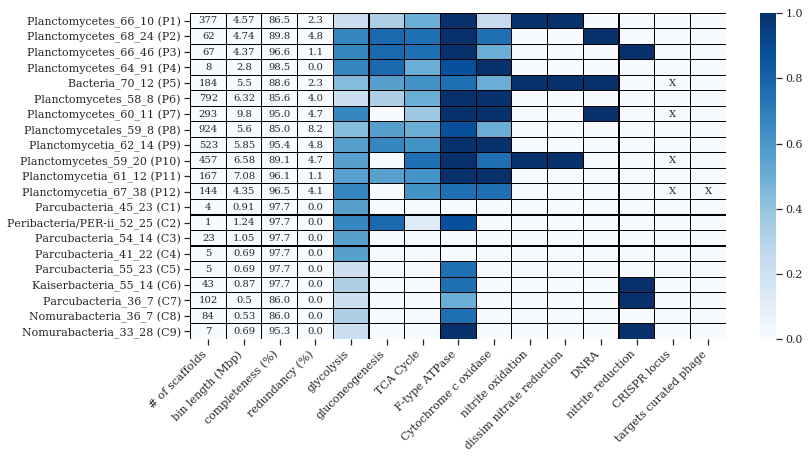

In [582]:
# re-organize
order = ["genome_label", "# of scaffolds", "bin length (Mbp)", "completeness (%)", "redundancy (%)"] + \
    [col for col in functions if col != "Function"] + ["CRISPR locus", "targets curated phage"]
# data
fdata = ftable.sort_values(["lineage", "id"], ascending=[False, True])[order]
for col in ["# of scaffolds", "bin length (Mbp)", "completeness (%)",\
            "redundancy (%)", "CRISPR locus", "targets curated phage"]:
    fdata[col] = 0
fdata.index = fdata["genome_label"]
fdata = fdata[order].drop("genome_label", axis=1)
# annotation
fanno = ftable.sort_values(["lineage", "id"], ascending=[False, True])[order]
fanno["bin length (Mbp)"] = fanno["bin length (Mbp)"].apply(lambda x: str(round(x/1e6,2)))
for col in ["completeness (%)", "redundancy (%)"]:
    fanno[col] = fanno[col].apply(lambda x: str(round(x,1)))
for col in functions:
    if col != "Function":
        fanno[col] = ""
for col in ["CRISPR locus", "targets curated phage"]:
    fanno[col] = fanno[col].apply(lambda x: "X" if x==True else "")
fanno.index = fanno["genome_label"]
fanno = fanno[order].drop("genome_label", axis=1)
# plot
sns.set_style({'font.family':'serif'})
plt.figure(figsize=[12, 6])
sns.heatmap(fdata, cmap="Blues", annot=fanno, fmt="",linewidths=0.1, linecolor="black")
plt.ylabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks(ha="right")
plt.savefig(rootdir + "dna/figures/aln_heatmap.svg", format="svg")

# wrap it up

### gtdb

In [594]:
cmdir(rootdir + "dna/genomes/tk")

In [595]:
call = "/shared/software/bin/gtdbtk classify_wf --cpus 20 -x .fna --genome_dir %s --out_dir %s" %(rootdir + "dna/genomes/dRep-workspace/dereplicated_genomes/", rootdir + "dna/genomes/tk")
print(call)

/shared/software/bin/gtdbtk classify_wf --cpus 20 -x .fna --genome_dir /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/genomes/dRep-workspace/dereplicated_genomes/ --out_dir /groups/banfield/projects/environmental/LacPavin/analysis/aln/dna/genomes/tk


In [655]:
# parse
gtresults = pd.concat([pd.read_csv(item, sep="\t") for item in glob.glob(rootdir + "dna/genomes/tk/gtdbtk.*.summary.tsv")])
gtresults.head()

,user_genome,classification,fastani_reference,fastani_reference_radius,fastani_taxonomy,fastani_ani,fastani_af,closest_placement_reference,closest_placement_radius,closest_placement_taxonomy,closest_placement_ani,closest_placement_af,pplacer_taxonomy,classification_method,note,"other_related_references(genome_id,species_name,radius,ANI,AF)",msa_percent,translation_table,red_value,warnings
0,LacPavin_0920_ALND_Nitrosoarchaeum_33_12,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,NaN,NaN,NaN,NaN,NaN,GCA_004297665.1,95.0,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,93.18,0.74,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,taxonomic classification defined by topology a...,NaN,"GCA_009697485.1, s__Nitrosarchaeum sp009697485...",76.03,11,0.992795,Genome not assigned to closest species as it f...
1,LacPavin_0920_ALND_Nitrosoarchaeum_limnia_33_41,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,NaN,NaN,NaN,NaN,NaN,GCA_000204585.1,95.0,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,84.40,0.71,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,taxonomic classification defined by topology a...,NaN,"GCA_009697485.1, s__Nitrosarchaeum sp009697485...",82.98,11,0.977146,Genome not assigned to closest species as it f...
0,LacPavin_0920_ALND_Actinobacteria_63_63,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,ANI,NaN,"GCA_903919215.1, s__UBA668 sp903919215, 95.0, ...",91.56,11,0.924173,NaN
1,LacPavin_0920_ALND_Alphaproteobacteria_58_11,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,NaN,NaN,NaN,NaN,NaN,GCA_003153235.1,95.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,77.60,0.24,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,taxonomic classification defined by topology a...,NaN,NaN,86.52,11,0.890579,NaN
2,LacPavin_0920_ALND_Alphaproteobacteria_61_16,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,NaN,NaN,NaN,NaN,NaN,GCA_009885515.1,95.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,77.28,0.23,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,taxonomic classification defined by topology a...,NaN,"GCA_003246795.1, s__SZUA-430 sp003246795, 95.0...",70.50,11,0.943741,NaN


### supp table

In [650]:
curated_md = pd.read_csv(rootdir + "tables/aln_genome_metadata_curated.tsv", sep="\t")
# naming
curated_md["genome_id"] = curated_md["genome"].map(genome2id).fillna("None")
# merge gtdb-tk + rnaseq
curated_md = curated_md.merge(gtresults[["user_genome", "classification"]], how="left", left_on="genome", right_on="user_genome").drop("user_genome", axis=1)
curated_md = curated_md.merge(rnatable.groupby("bin", as_index=False).aggregate({"read_count":"sum"}), how="left", left_on="genome", right_on="bin")
curated_md.head()

,genome,lineage,checkm_completeness,checkm_contamination,scaffold_number,genome_id,classification,bin,read_count
0,LacPavin_0920_ALND_Actinobacteria_63_63,Actinobacteria,93.59,2.14,18,None,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,LacPavin_0920_ALND_Actinobacteria_63_63,2734
1,LacPavin_0920_ALND_Mycobacterium_68_14,Actinobacteria,90.26,5.05,462,None,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,LacPavin_0920_ALND_Mycobacterium_68_14,854
2,LacPavin_0920_ALND_Alphaproteobacteria_58_11,Alphaproteobacteria,96.16,2.20,87,None,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,LacPavin_0920_ALND_Alphaproteobacteria_58_11,1181
3,LacPavin_0920_ALND_Alphaproteobacteria_61_16,Alphaproteobacteria,76.93,2.33,417,None,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,LacPavin_0920_ALND_Alphaproteobacteria_61_16,3993
4,LacPavin_0920_ALND_Parvibaculum_lavamentivoran...,Alphaproteobacteria,95.16,9.28,53,None,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,LacPavin_0920_ALND_Parvibaculum_lavamentivoran...,10245


In [651]:
# add in bin size
bin_sizes = {}
for genome in glob.glob(rootdir + "dna/genomes/final_genomes/*[0-9].fna"):
    tmp = 0
    for record in SeqIO.parse(open(genome), "fasta"):
        tmp += len(record.seq)
    bin_sizes[os.path.basename(genome).split(".")[0]] = tmp

curated_md["bin_length"] = curated_md["genome"].map(bin_sizes)
curated_md["genome"] = curated_md["genome"].apply(lambda x: x.replace("LacPavin", "LakeFargette"))

In [657]:
# add in ncbi info
curated_md["bioproject"] = "PRJNA757735"
### TODO

In [658]:
supp_table = curated_md[["bioproject", "genome", "genome_id", "lineage", "classification", "bin_length", "scaffold_number", \
                         "checkm_completeness", "checkm_contamination", "read_count"]]
supp_table.columns = ["bioproject", "genome_name", "genome_id", "lineage", "gtdbtk_classification", "bin_length_bp", "num_scaffolds", \
                      "checkm_completeness_percent", "checkm_redundancy_percent", "rna_read_count"]
supp_table.to_csv(rootdir + "tables/genome_supp_table.tsv", sep="\t", index=False)
supp_table.head()

,bioproject,genome_name,genome_id,lineage,gtdbtk_classification,bin_length_bp,num_scaffolds,checkm_completeness_percent,checkm_redundancy_percent,rna_read_count
0,PRJNA757735,LakeFargette_0920_ALND_Actinobacteria_63_63,None,Actinobacteria,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,3206627,18,93.59,2.14,2734
1,PRJNA757735,LakeFargette_0920_ALND_Mycobacterium_68_14,None,Actinobacteria,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,2909805,462,90.26,5.05,854
2,PRJNA757735,LakeFargette_0920_ALND_Alphaproteobacteria_58_11,None,Alphaproteobacteria,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,2110177,87,96.16,2.20,1181
3,PRJNA757735,LakeFargette_0920_ALND_Alphaproteobacteria_61_16,None,Alphaproteobacteria,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,3485382,417,76.93,2.33,3993
4,PRJNA757735,LakeFargette_0920_ALND_Parvibaculum_lavamentiv...,None,Alphaproteobacteria,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,3624273,53,95.16,9.28,10245
